In [1]:
# GET SOME IMAGE DATA
# MNIST is nice & cheap
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)


import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    
from matplotlib import pyplot
import numpy as np

print(x_train.shape)
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")

(50000, 784)


In [3]:
# Generator Structure
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [18]:
# Root directory for dataset
dataroot = "./data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

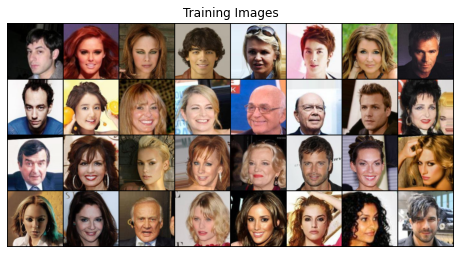

In [19]:
# Set up dataloaders
# ImageFolder dataloader applies image transformations
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

# Plot some training images
real_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [3]:
# IMPLEMENT THE RESNET
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from typing import Type, Any, Callable, Union, List, Optional
import blocks


In [ ]:
m = blocks.ResUNet_A_miniBlock(10)
n = blocks.Conv2DN(10,20)
p = blocks.ResUNet_A_Block_4(10, _kernel_size=(3,3), _dilation_rates=[1,3,5,7])
ds = blocks.DownSample(10)
mp = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=0, dilation=1, return_indices=False, ceil_mode=False)

enc = blocks.MultiScale_Classifier(10)
a = torch.randn(1, 10, 256, 256)


print(a.shape)
print(m(a).shape)
print(n(a).shape)
print(p(a).shape)
print(ds(a).shape)
print(enc(a).shape)
print(enc(a))

In [ ]:
# Generator

# SELF-ATTENTION MODULE
